# Get Integrated Level Fluxes For Solar Reflected and Thermal Radiation

Here in this notebook we work on getting the pressure-dependent level fluxes and also comparing these level fluxes with our three methods of getting opacities (resort-rebin, resampled, and preweighted)

In [1]:
import picaso.justdoit as jdi
import numpy as np
import picaso.justplotit as jpi

In [2]:
import os
mh = '0.0'#'+0.0' #log metallicity
CtoO = '0.46'# # CtoO absolute ratio
ck_db_path = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted', f'sonora_2121grid_feh{mh}_co{CtoO}.hdf5')
sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat')

## Set up the PICASO connection for three test cases (mono and correlated-k)

In [3]:
#monochromatic opacities pulling the default
opacity_mono = jdi.opannection()
#opacity datase with preweighted ck tables
opacity_ck = jdi.opannection(ck_db=ck_db_path,
                             method='preweighted')
#resort rebin method with pre-described molecules
gases_fly = ['H2O', 'CH4', 'H2', 'CO', 'NH3', 'TiO', 'VO', 'Na', 'K','CO2', 'H', 'He']
opacity_resort =  jdi.opannection(method='resortrebin',
                                  preload_gases=gases_fly)

#lets book-keep these to compare
calc = {'mono':  opacity_mono,
        'ck':    opacity_ck,
        'resort': opacity_resort}

cases = {}
df = {}

# Define some parameters for the simulation
stellar_temp   = 6000
stellar_met    = 0.0
stellar_logg   = 4.0
orbital_sep    = 0.05
stellar_radius = 1
rsol = 6.957e8
au   = 1.496e11
blackbody_temp = 1000

#run the get level-fluxes framework for these three different methods
for key in ['mono','ck', 'resort']:
    cases[key] = jdi.inputs()

    cases[key].approx(get_lvl_flux=True)

    # Set common parameters: phase angle and gravity.
    cases[key].phase_angle(0)
    cases[key].gravity(radius=1, radius_unit=jdi.u.Unit('R_jup'),mass=1, mass_unit=jdi.u.Unit('M_jup'))

    # Set stellar parameters (same for both)
    cases[key].star(calc[key],
                    stellar_temp,
                    stellar_met,
                    stellar_logg,
                    radius=stellar_radius,
                    radius_unit=jdi.u.Unit('R_sun'),
                    semi_major=orbital_sep,
                    semi_major_unit=jdi.u.Unit('au'))
    Teff = 1000
    cases[key].sonora(sonora_profile_db, Teff, chem='grid')
    atm = cases[key].inputs['atmosphere']['profile']

    # Hardcode a blackbody for testing
    atm.temperature = blackbody_temp
    cases[key].atmosphere(df=atm)
    df[key] = cases[key].spectrum(calc[key], full_output=True, calculation='thermal+reflected')

/home/nbatalh1/codes/picaso/picaso/opacity_factory.py:2321: UserWarning: Found a CIA molecule, which doesnt require a correlated-K table. The gaseous opacity of H will not be included unless you first create a CK table for it. Found a CIA molecule, which doesnt require a correlated-K table. The gaseous opacity of He will not be included unless you first create a CK table for it.
  warnings.warn(' '.join(np.unique(msg)), UserWarning)


## Grab the thermal fluxes, reflected fluxes, and pressure levels from the full output

In [4]:
# Get the data out of the picaso run
thermal_plus = df['ck']['full_output']['level']['thermal_fluxes']['flux_plus']
thermal_minus = df['ck']['full_output']['level']['thermal_fluxes']['flux_minus']
reflected_plus = df['ck']['full_output']['level']['reflected_fluxes']['flux_plus']
reflected_minus = df['ck']['full_output']['level']['reflected_fluxes']['flux_minus']
pressures = df['ck']['full_output']['level']['pressure']

# Sum the binned fluxes to get the bolometric values
integrated_thermal_plus = np.sum(thermal_plus, axis=1)
integrated_thermal_minus = np.sum(thermal_minus, axis=1)
integrated_reflected_plus = np.sum(reflected_plus, axis=1)
integrated_reflected_minus = np.sum(reflected_minus, axis=1)

## Plot the thermal and reflected layer fluxes

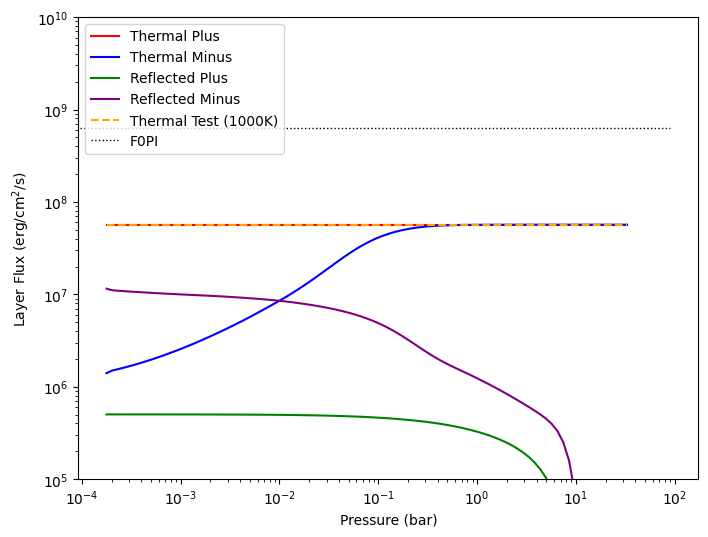

In [5]:
# Compute incident flux
plt=jpi.plt
F0PI = (5.67e-5 * stellar_temp ** 4) * (((stellar_radius * rsol) / (orbital_sep * au)) ** 2)

plt.figure(figsize=(8, 6))

# Plot thermal and reflected fluxes, both up and down
plt.plot(pressures, integrated_thermal_plus, label='Thermal Plus', color='red')
plt.plot(pressures, integrated_thermal_minus, label='Thermal Minus', color='blue')
plt.plot(pressures, integrated_reflected_plus, label='Reflected Plus', color='green')
plt.plot(pressures, integrated_reflected_minus, label='Reflected Minus', color='purple')

# Add reference flux lines for thermal and starlight
plt.plot(pressures,
         [5.67e-5 * blackbody_temp ** 4] * len(pressures),
         label='Thermal Test (1000K)',
         color='orange',
         linestyle='dashed')

plt.plot([np.sum(F0PI)] * len(pressures),
         label='F0PI',
         linestyle='dotted',
         linewidth=1,
         color='black')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e5, 1e10)
plt.ylabel(r'Layer Flux (erg/cm$^2$/s)')
plt.xlabel('Pressure (bar)')
plt.legend(loc='best')